# パイプラインによるワークフローの効率化

### Breast Cancer Wiscnsinデータセットを読み込む

In [1]:
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/"
                 "breast-cancer-wisconsin/wdbc.data", header=None)

In [2]:
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
le.transform(["M", "B"])

array([1, 0], dtype=int64)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

### パイプラインで変換器と推定器を結合する

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import warnings
warnings.simplefilter("ignore")

# 連結する処理としてスケーリング、主成分分析、ロジスティック回帰を指定
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
print("Test Accuracy: %.3f" % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.930


### 層化k分割交差検証

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# 分割データ、分割数、乱数生成器の状態を指定し、
# 層化k分割交差検証イテレータを表すStratifiedKFoldクラスのインスタンス化
kfold = StratifiedKFold(n_splits=10, random_state=0).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print("Fold: %2d, Class dist.: %s, Acc: %.3f" %
          (k+1, np.bincount(y_train[train]), score))

Fold:  1, Class dist.: [256 153], Acc: 0.957
Fold:  2, Class dist.: [256 153], Acc: 0.978
Fold:  3, Class dist.: [256 153], Acc: 0.935
Fold:  4, Class dist.: [256 153], Acc: 0.978
Fold:  5, Class dist.: [256 153], Acc: 1.000
Fold:  6, Class dist.: [257 153], Acc: 0.978
Fold:  7, Class dist.: [257 153], Acc: 0.956
Fold:  8, Class dist.: [257 153], Acc: 0.911
Fold:  9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 1.000


In [8]:
print("\nCV accuracy: %.3f +/- %.3f " % (np.mean(scores), np.std(scores)))


CV accuracy: 0.967 +/- 0.027 


In [9]:
from sklearn.model_selection import cross_val_score

# 推定器estimator、トレーニングデータX、予測値y、分割数cv、CPU数n_jobsを指定
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train, y=y_train,
                         cv=10, n_jobs=1)
print("CV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV accuracy: 0.967 +/- 0.027


### 学習曲線関数を使ってモデルを評価

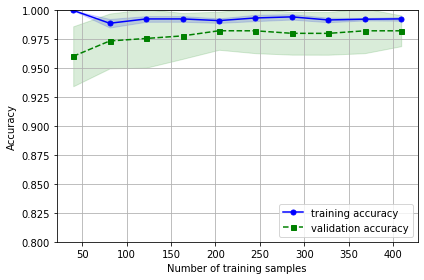

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty="l2",random_state=0))
# learning_curve関数で交差検証による正解率を算出
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
         color="blue", marker="o",
         markersize=5, label="training accuracy")
# fill_between関数で平均±標準偏差の幅を塗りつぶす
# トレーニングデータのサイズtrain_sizes, 透明度alpha, カラー"blue"を引数に指定
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color="blue")
plt.plot(train_sizes, test_mean,
         color="green", linestyle="--",
         marker="s", markersize=5,
         label="validation accuracy")
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color="green")
plt.grid()
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

### 検証曲線を使って過学習と学習不足を明らかにする

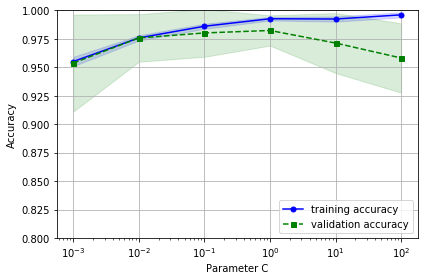

In [24]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
# validation_curve関数によりモデルのパラメータを変化させ、交差検証による正解率を算出
# clf_CはLogisticRegressionオブジェクトのパラメータ
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train, y=y_train,
                                             param_name="logisticregression__C",
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
         color="blue", marker="o",
         markersize=5,
         label="training accuracy")
plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color="blue")
plt.plot(param_range, test_mean,
         color="green", linestyle="--",
         marker="s", markersize=5,
         label="validation accuracy")
plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std, alpha=0.15,
                 color="green")
plt.grid()
plt.xscale("log")
plt.legend(loc="lower right")
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

### グリッドサーチを使ったハイパーパラメータのチューニング

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=0))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{"svc__C": param_range, "svc__kernel": ["linear"]},
              {"svc__C": param_range, "svc__gamma": param_range, "svc__kernel":["rbf"]}]

# ハイパーパラメータ値のリストparam_gridを指定し、グリッドサーチを行うGridSearchCVクラスをインスタンス化
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
# モデルを最良スコアを出力
print(gs.best_score_)

# 最良スコアとなるパラメータ値を出力
print(gs.best_params_)

0.978021978021978
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [26]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print("Test accuracy: %.3f" % clf.score(X_test, y_test))

Test accuracy: 0.965


In [28]:
# 内側のループ(パラメータをチューニング)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring="accuracy",
                  cv=2)

# 外側のループ(最適なパラメータでトレーニング)
scores = cross_val_score(gs, X_train, y_train, scoring="accuracy", cv=5)
print("CV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV accuracy: 0.978 +/- 0.010


In [30]:
from sklearn.tree import DecisionTreeClassifier

# ハイパーパラメータ値として決定木の深さパラメータを指定し、
# グリッドサーチを行うGridSearchCVクラスをインスタンス化
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{"max_depth": [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring="accuracy",
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring="accuracy", cv=5)
print("CV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV accuracy: 0.934 +/- 0.012


### 混同行列

In [32]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

# テストと予測のデータから混同行列を生成
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[69  3]
 [ 2 40]]


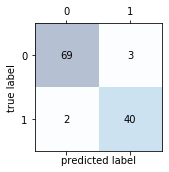

In [33]:
# 図のサイズを指定
fig, ax = plt.subplots(figsize=(2.5, 2.5))
# matshow関数で行列からヒートマップを描画
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]): # クラス0の繰り返し処理
    for j in range(confmat.shape[1]): # クラス1の繰り返し処理
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center") # 件数を表示
        
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.tight_layout()
plt.show()

In [42]:
# 適合率、再現率、F1スコアを出力
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print("Percision: %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Recall: %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("F1: %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

Percision: 0.930
Recall: 0.952
F1: 0.941


In [45]:
# カスタムの性能指標を出力
from sklearn.metrics import make_scorer, f1_score

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9825907119856045
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### ROC曲線のプロット

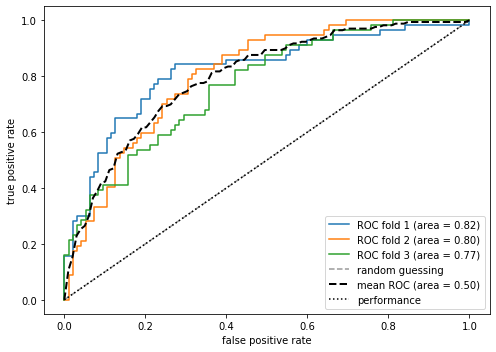

In [53]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

# スケーリング、主成分分析、ロジスティック回帰を指定して、Pipelineクラスをインスタンス化
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty="l2", random_state=0, C=100.0))
# 2つの特徴量を抽出
X_train2 = X_train[:, [4, 14]]
# 層化k分割交差検証イテレータを表すStratifiedKFoldクラスをインスタンス化
cv = list(StratifiedKFold(n_splits=3, random_state=0).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr =0.0
# 0から1までの間で100個の要素を生成
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    # predict_probaメソッドで確率を予測、fitメソッドでモデルに適合させる
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    # roc_curve関数でROC曲線の性能を計算してプロット
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr) # FPR(x軸)とTPR(y軸)を線形補間
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr) # 曲線下面積(AUC)を計算
    plt.plot(fpr, tpr, label="ROC fold %d (area = %0.2f)" % (i+1, roc_auc))
    
# 当て推量をプロット
plt.plot([0, 1],
         [0, 1],
         linestyle="--",
         color=(0.6, 0.6, 0.6),
         label="random guessing")
# FPR, TPR, ROC AUC それぞれの平均を計算してプロット
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_tpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, "k--", label="mean ROC (area = %0.2f)" % mean_auc, lw=2)
# 完全に予測が正解したときのROC曲線をプロット
plt.plot([0, 0, 1], [0, 0, 1], linestyle=":", color="black", label="performance")
# グラフの項目を指定
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 他クラス分類のための性能指標

In [54]:
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average="micro")

### Breast Cancer Wisconsinデータセットから不均衡なデータセットを作成

In [55]:
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

In [56]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

### 少数派クラスのアップサンプリングに役立つresample

In [61]:
from sklearn.utils import resample

print("Number of class 1 samples before:", X_imb[y_imb == 1].shape[0])

# サンプルの個数がクラス0と同じになるまで新しいサンプルを復元抽出
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0], random_state=0)
print("Number of class 1 samples after:", X_upsampled.shape[0])

Number of class 1 samples before: 40
Number of class 1 samples after: 357


### アップサンプリングしたクラス0のサブセットを結合させることで、均衡なデータセットを取得できる

In [64]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0